In [1]:
%pip install -q yfinance tensorflow mplfinance pandas_datareader dictionary datetime matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import mplfinance as mpf          # require matplotlib and pandas to plot financial data

# 1. Data loading

In [4]:
# from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
from datetime import datetime, timedelta

plt.style.use("fivethirtyeight")
%matplotlib inline

yf.pdr_override()

# Set up the stocks, start and end times for data download.
stocks = ['NVDA', 'TSLA', 'AAPL', 'GOOG', 'MSFT']
end = datetime.now()
start = end - timedelta(days=59)    # delta: 60 days

trends = {}

for stock in stocks:
  trends[stock] = pdr.get_data_yahoo(stock, start=start, end=end, interval="15m")    # interval: 15m

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
trends['NVDA']

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-02-29 09:30:00,792.500000,798.299927,791.715027,794.109985,794.109985,6863344
2024-02-29 09:45:00,794.054993,796.729980,790.070007,794.779297,794.779297,3212402
2024-02-29 10:00:00,794.679993,797.849976,791.099976,792.020081,792.020081,2411887
2024-02-29 10:15:00,792.200012,795.400024,791.650085,793.489990,793.489990,1531932
2024-02-29 10:30:00,793.466003,796.450012,792.500000,794.179993,794.179993,1444651
...,...,...,...,...,...,...
2024-04-26 14:45:00,871.500000,875.789978,868.859985,875.781921,875.781921,1497752
2024-04-26 15:00:00,875.682007,876.520020,872.750000,873.505005,873.505005,1154810
2024-04-26 15:15:00,873.500000,878.485291,872.600098,878.070007,878.070007,1495450


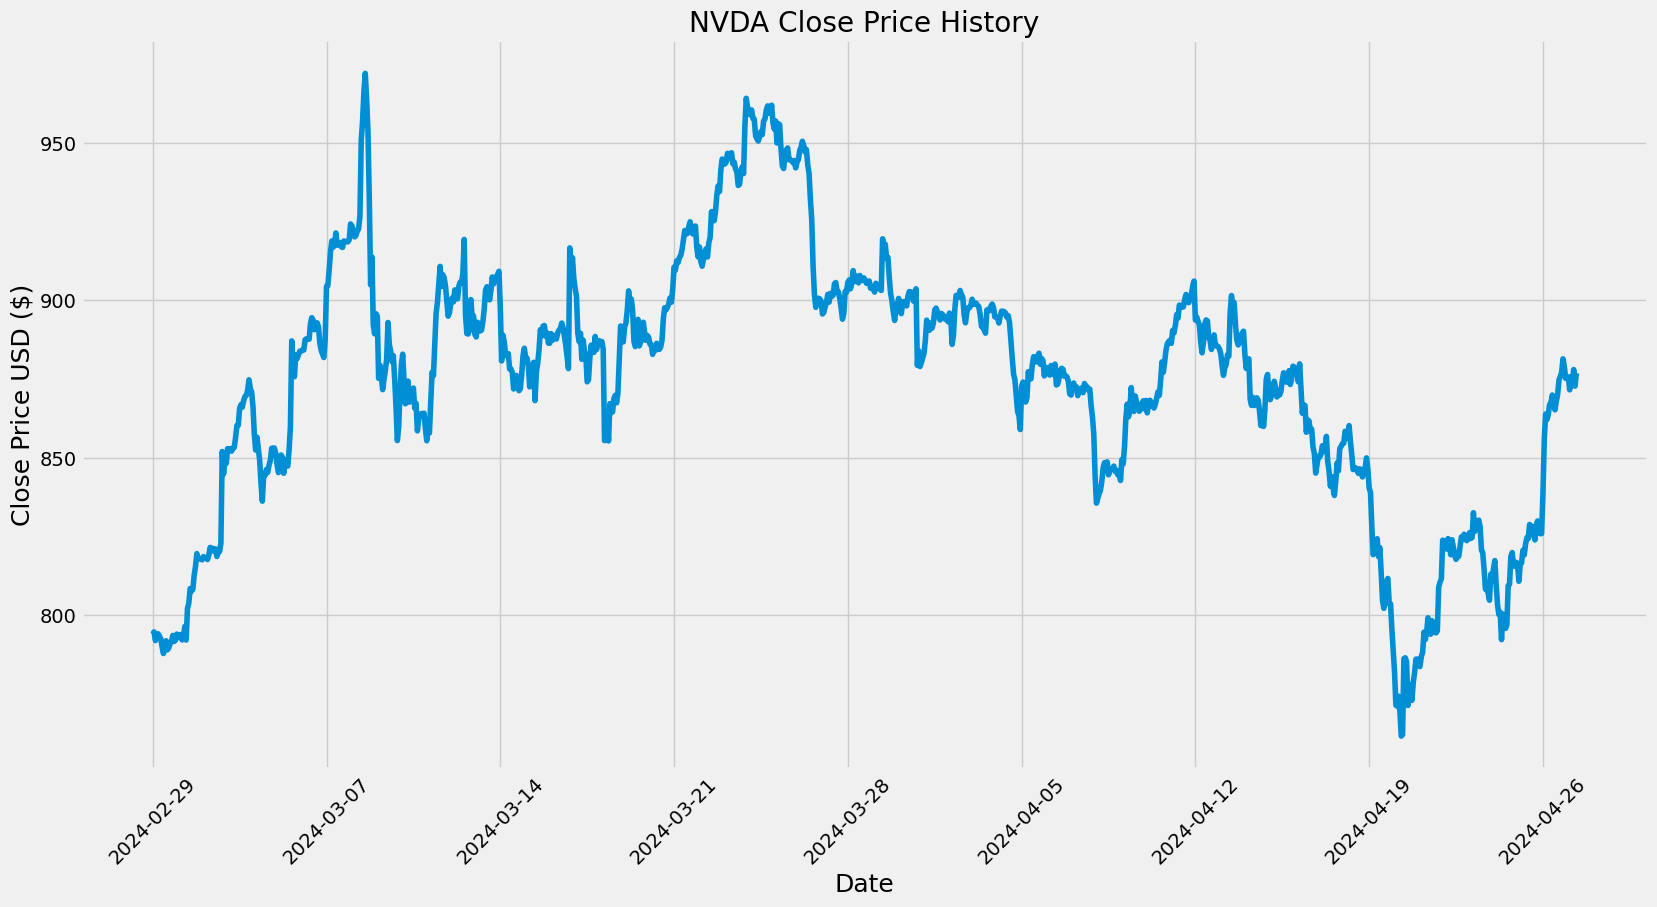

In [6]:
stock = 'NVDA'
df = trends[stock]

plt.figure(figsize=(18,9))
plt.title(stock + ' Close Price History')
plt.plot(range(df.index.size), df['Close'])
ticks = df.index.indexer_at_time('09:30')[::-5]    # step in days
plt.xticks(ticks ,df.index.date[ticks] ,rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

# 2. Data Preprocess

In [8]:
# Used to normalize the data (Not used)
# from sklearn.preprocessing import MinMaxScaler

# Used to standardize the data
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
raw_data = df.filter(['Close'])

dataset = raw_data.copy().to_numpy()

# Calculate Price Difference
for i in range(0, dataset.size-1):
    dataset[i] = dataset[i+1] - dataset[i]

dataset = np.delete(dataset, -1, 0)

train_data_n = int(len(dataset)*0.9)
test_data_n = len(dataset) - train_data_n

train_data_n, test_data_n, len(dataset)
print(dataset)

[[ 0.66931152]
 [-2.75921631]
 [ 1.46990967]
 ...
 [ 4.56500244]
 [-5.27001953]
 [ 4.10003662]]


In [10]:
scaler = StandardScaler(with_mean=False)  #
# scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[ 0.13675711],
       [-0.56377699],
       [ 0.30033935],
       ...,
       [ 0.93274432],
       [-1.07679696],
       [ 0.83774015]])

In [11]:
# Training Set & Validation Set Preprocess
train_data = scaled_data[0:train_data_n, :]

x_train = []
y_train = []

sequence_size = 60

for i in range(sequence_size, len(train_data)):
  x_train.append(train_data[i-sequence_size:i, 0])
  y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape
# x_train

(898, 60, 1)

In [12]:
# Testing Set Preprocess
test_data = scaled_data[train_data_n - 60: train_data_n, :]

x_test = []
y_test = dataset[train_data_n: , :]

for i in range(0, sequence_size):
  partial_sequence = test_data[i:sequence_size, 0]
  x_test.append(partial_sequence)

for i in range(sequence_size, test_data_n):
  x_test.append([0])

x_test = np.array(pad_sequences(x_test, maxlen=sequence_size, padding='post', dtype='float32'))

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
x_test.shape, y_test.shape
# print(y_test)

((107, 60, 1), (107, 1))

# 3. Data Training

In [14]:
# From Nvidia lab 6
from keras.preprocessing.sequence import pad_sequences

# Embedding and dropout used in nvidia.
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [15]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.summary()

C:\Users\limli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,929 (503.63 KB)

 Trainable params: 128,929 (503.63 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer='adam', loss='mean_absolute_error')

model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.6497
Epoch 2/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.6778
Epoch 3/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.6670
Epoch 4/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 0.6684
Epoch 5/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.6673


# 4. Data Prediction

In [18]:
predictions_list = []

for i in range(0, test_data_n):
  single_test = np.reshape(x_test[i], (1, x_test.shape[1], 1))

  prediction = model.predict(single_test)

  predictions_list.append(prediction[0])

  if (test_data_n - i <= sequence_size and test_data_n - i > 0):
    for j, k in zip(range(i+1, test_data_n), range(sequence_size-1, sequence_size-test_data_n+i, -1)): #sequence_size
      x_test[j, k] = prediction
  else:
    for j in range(i+1, i+sequence_size+1):
      x_test[j, -j+i] = prediction


np_predictions = np.array(predictions_list)

predictions = scaler.inverse_transform(np_predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

4.523447448733718

In [41]:
# print(predictions)

In [20]:
predicted_price = np.zeros([predictions.size+1, 1], dtype='float64')
#print(predicted_price.size)

predicted_price[0] = df['Close'].iloc[train_data_n]

for i in range(1, predictions.size+1):
    predicted_price[i] = predicted_price[i-1] + predictions[i-1]
# print(predicted_price)

                          Close  Predictions
Datetime                                    
2024-04-22 15:00:00  797.090027   797.090027
2024-04-22 15:15:00  794.619995   797.168064
2024-04-22 15:30:00  794.479980   797.246101
2024-04-22 15:45:00  795.099976   797.324138
2024-04-23 09:30:00  808.955017   797.402176
...                         ...          ...
2024-04-26 14:45:00  875.781921   805.127856
2024-04-26 15:00:00  873.505005   805.205894
2024-04-26 15:15:00  878.070007   805.283931
2024-04-26 15:30:00  872.799988   805.361968
2024-04-26 15:45:00  876.900024   805.440005

[108 rows x 2 columns]


C:\Users\limli\AppData\Local\Temp\ipykernel_328\596022687.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predicted_price


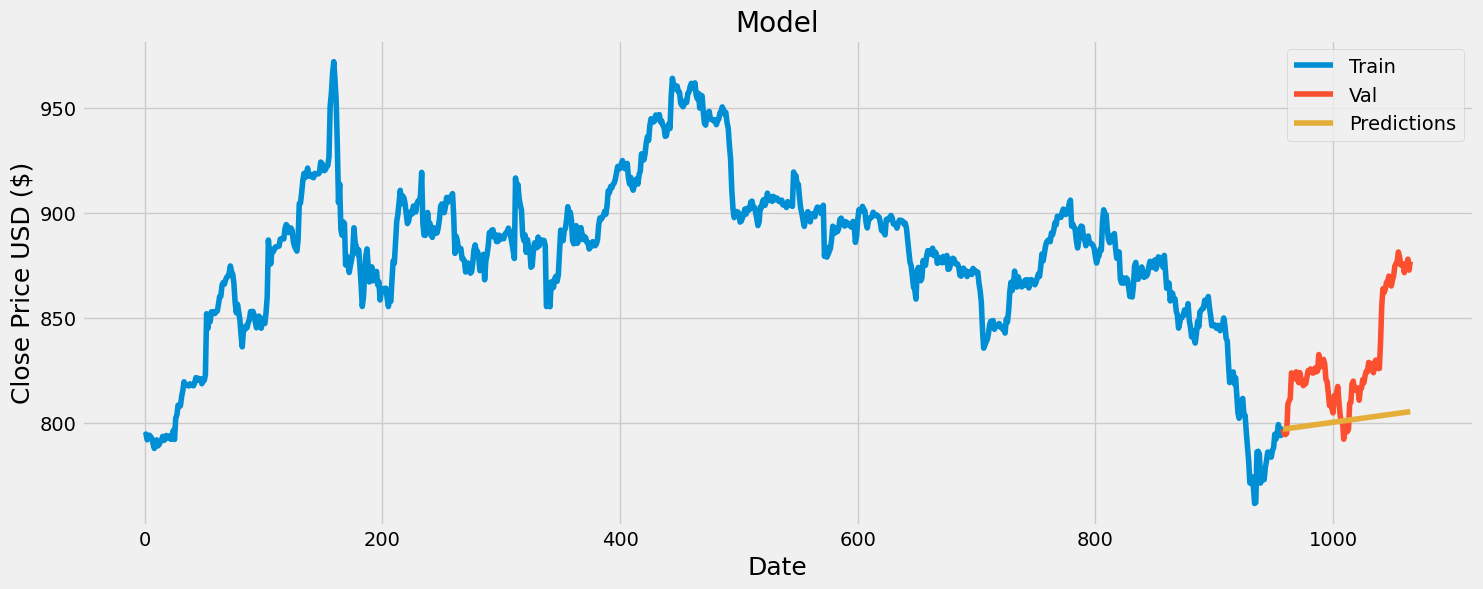

In [21]:
train = raw_data[:train_data_n]
valid = raw_data[train_data_n:]
valid['Predictions'] = predicted_price

#print(train)
print(valid)

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(range(train.index.size), train['Close'])
plt.plot(range(train.index.size, train.index.size + valid.index.size), valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()